In [2]:
#Basic tutorial of RL environment classes and agent classes completed February 2021 by Annik Carson
import numpy as np
import matplotlib.pyplot as plt

import env_functions as ef
from rl_utils import running_mean
from importlib import reload

# Fundamental Building Blocks of the Reinforcement Learning Problem
A reinforcement learning problem is one where we are interested in how an agent learns from its interaction with the environment it operates in. The agent gets information from the environment about what state it is in, and chooses how to act in that state. The learning problem is about how to make better and better choices with the information you have. 

<img src="RL_agt.png" width="500"/>

Here we will focus on what pieces go into an agent so that it can learn to make choices. We have already seen the agent which just uses the random policy. However, this does not take into account any information about performance, and has no mechanism for altering its policy toward something better. In this section we will show some examples of how to build agents that learn from experience.  

# What's in an agent 
An agent takes in information of state and produces an action
The most basic agent will just choose actions randomly

In [3]:
class RandomAgent(object):
    def __init__(self, num_actions):
        self.num_actions = num_actions
    def select_action(self, state):
        # state actually does nothing in this agent, but we will want our action selection
        # in later agents to be based on the state we're in
        action = np.random.choice(self.num_actions)
        return action

## Value-Based Agents

In [4]:
class Q_Agent(object):
    def __init__(self, env, learning_rate=0.07, discount=0.9, epsilon=1):
        self.num_actions = env.nactions
        self.action_space = np.arange(self.num_actions)

        # this agent selects actions from a table of state,action values which we initalize randomly
        self.q_table = np.random.uniform(low=-2, high=0.1, size=(env.nstates, env.nactions))
        #self.q_table = np.zeros((env.nstates, env.nactions))

        # parameters for learning
        self.epsilon       = epsilon
        self.learning_rate = learning_rate
        self.discount      = discount

    def choose_action(self, state):
        # this agent uses epsilon-greedy action selection, meaning that it selects 
        # the greedy (highest value) action most of the time, but with epsilon probability
        # it will select a random action -- this helps encourage the agent to explore
        # unseen trajectories
        if np.random.random()>self.epsilon:
            # take the action which corresponds to the highest value in the q table at that row (state)
            action = np.argmax(self.q_table[state]) 
        else:
            action=np.random.choice(self.action_space)
        return action


    def update_q_table(self, current_state, current_action, reward, new_state):
        # this function describes how the Q table gets updated so the agent can make 
        # better choices based on what it has experienced from the environment 
        current_q = self.q_table[ current_state, current_action]
        max_future_q = np.max(self.q_table[new_state,:])

        new_q = (1-self.learning_rate)*current_q + self.learning_rate*(reward + self.discount*max_future_q)
        self.q_table[current_state, current_action] = new_q
        
#SARSA agent class
class SARSA_Agent(Q_Agent):
    def __init__(self, env, learning_rate=0.1, discount=0.95, epsilon=1.0):
        super().__init__(env, learning_rate=learning_rate , discount=discount, epsilon=epsilon)

    #updates q values after each step 
    # similar to Q update but with one key difference -- we use the action we *actually* took
    # rather than guessing we took the max value action
    # with epsilon probability, we will have actually taken a random action, so SARSA wants to account for that 
    def update_q_table(self,current_state, current_action, reward, next_state, next_action):
        current_q = self.q_table[ current_state, current_action]
        future_q = self.q_table[ next_state, next_action] # np.max(self.q_table[new_state,:])

        new_q = (1-self.learning_rate)*current_q + self.learning_rate*(reward + self.discount*future_q)
        self.q_table[current_state, current_action] = new_q


## Because Q and SARSA need to keep track of slightly different information, we will write two functions for how they navigate the environment 

In [5]:
def q_navigate(env, q_agent, num_episodes, random_start=False, start=0):
    # set how we will decay the randomness of action selection over the course of training
    start_eps_decay = 1
    end_eps_decay = num_episodes//2
    epsilon_decay_value = q_agent.epsilon/(end_eps_decay-start_eps_decay)

    # initialize empty list for keeping track of rewards achieved per episode
    reward_tracking=[]
    max_steps= 1000
    
    for episode in range(num_episodes):
        env.reset()
        # initalize reward counter
        total_reward=0

        # get first state and action
        if random_start:
            state=np.random.choice(env.nstates)
        else:
            state=start
        
        for step in range(max_steps):
            action = q_agent.choose_action(state)
            # take a step in the environment
            next_state, reward, done, _ = env.step(action)

            total_reward+=reward

            if not done:
                q_agent.update_q_table(state, action, reward, next_state)
            else:
                q_agent.q_table[state, action] = 0
                break
            state=next_state

        reward_tracking.append(total_reward)

        if end_eps_decay >= episode >= start_eps_decay:
            q_agent.epsilon -= epsilon_decay_value

    return reward_tracking

def sarsa_navigate(env, sarsa_agent, num_episodes, random_start=False, start=0): # takes sarsa_agent as input 
    #-- will not work w Q_agent bc takes additional argument of next_state in update_q_table function
    # set how we will decay the randomness of action selection over the course of training
    start_eps_decay = 1
    end_eps_decay = num_episodes//2
    epsilon_decay_value = sarsa_agent.epsilon/(end_eps_decay-start_eps_decay)

    # initialize empty list for keeping track of rewards achieved per episode
    reward_tracking=[]
    max_steps= 100
    
    
    for episode in range(num_episodes):
        env.reset()
        # initalize reward counter
        total_reward=0

        # get first state and action
        if random_start:
            state=np.random.choice(env.nstates)
        else:
            state=start
        action = sarsa_agent.choose_action(state)

        for step in range(max_steps):
            # take a step in the environment
            next_state, reward, done, _ = env.step(action)

            total_reward+=reward

            if not done:
                next_action = sarsa_agent.choose_action(next_state)
                sarsa_agent.update_q_table(state, action, reward, next_state, next_action)
            else:
                sarsa_agent.q_table[state, action] = 0
                break
            state=next_state
            action=next_action

        reward_tracking.append(total_reward)

        if end_eps_decay >= episode >= start_eps_decay:
            sarsa_agent.epsilon -= epsilon_decay_value

    return reward_tracking

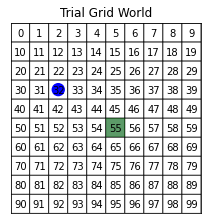

In [14]:
reload(ef)
n_rows, n_cols = 10,10
step_penalization = -0.1
env = ef.GridWorld(rows=n_rows,cols=n_cols,
                  #obstacles=[(2,2),(2,3),(2,4),(3,2),(2,5),(2,6),(2,7),(2,8)], 
                  rewards={(5,5):10},
                  #terminals=[(5,5)],
                  step_penalization=step_penalization,
                  actionlist=['Down','Up','Right','Left'],
                  view_labels=True,
                  #finish_after_first_reward=False
                  )

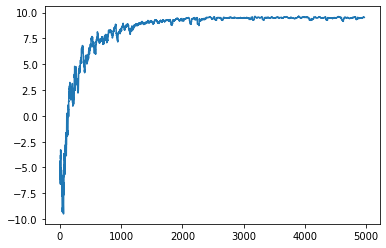

In [15]:
qlearner = Q_Agent(env)

rewards = q_navigate(env, qlearner, num_episodes=5000)
plt.plot(running_mean(rewards,N=30))

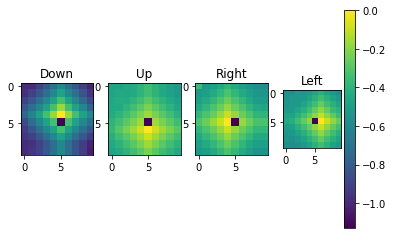

In [18]:
fig, ax = plt.subplots(1,4)
for i in range(4):
    f = ax[i].imshow(qlearner.q_table[:,i].reshape(n_rows,n_cols))
    ax[i].set_title(env.action_list[i])
    
# To Do == fix colorbar size 
plt.colorbar(f)
plt.show()

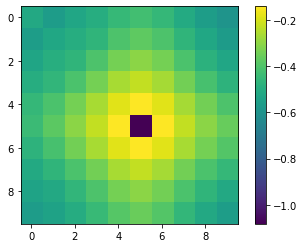

In [19]:
a = np.mean(qlearner.q_table, axis=1).reshape(n_rows,n_cols)

f = plt.imshow(a)
plt.colorbar(f)

Why does the location of the reward show no value?